In [ ]:
# using a histogram to record the frequnetly query region
# when split according to query, only query in the above region is considered
# for other region, perform LKD? or KD

In [1]:
import import_ipynb
import numpy as np
import copy
import rtree
from rtree import index

In [452]:
# assume hist is 2D
def CreatePrefixSumHist(hist):
    
    # in case it's not in np
    hist = np.array(hist)
    
    # accumulation in second dimension
    for i in range(hist.shape[0]):
        for j in range(1,hist.shape[1]):
            hist[i,j] += hist[i,j-1]
    
    # now do the accumulation in first dimension
    for j in range(hist.shape[1]):
        for i in range(1,hist.shape[0]):
            hist[i,j] += hist[i-1,j]
            
    return hist

def CreatePrefixSumHist3D(hist):
    
    # in case it's not in np
    hist = np.array(hist)
    
    # accumulation on the third dimension
    for i in range(hist.shape[0]):
        for j in range(hist.shape[1]):
            for k in range(1,hist.shape[2]):
                hist[i,j,k] += hist[i,j,k-1]
    
    # now do the accumulation on the second dimension
    for k in range(hist.shape[2]):
        for i in range(hist.shape[0]):
            for j in range(1,hist.shape[1]):
                hist[i,j,k] += hist[i,j-1,k]
    
    # now do the accumulation on the first dimension
    for j in range(hist.shape[1]):
        for k in range(hist.shape[2]):
            for i in range(1,hist.shape[0]):
                hist[i,j,k] += hist[i-1,j,k]
            
    return hist


# def CreatePrefixSumHistND(hist):
    
#     # in case it's not in np
#     hist = np.array(hist)
#     shape_info = [shape for shape in hist.shape]
#     for dim in range(len(hist.shape)):
#     using recursion?

# equal_width histogram, for 2D
# query is in the form of kdnode[0], domain indicate the global domain, also in the form of kdnode[0]
def QueryAccuHist(accu_hist, query, domain):
    
    bins = accu_hist.shape
    
    dim_1_lower_index = int((query[0][0]-domain[0][0])/(domain[0][1]-domain[0][0])*bins[0])
    dim_1_upper_index = int((query[0][1]-domain[0][0])/(domain[0][1]-domain[0][0])*bins[0])
    dim_2_lower_index = int((query[1][0]-domain[1][0])/(domain[1][1]-domain[0][0])*bins[1])
    dim_2_upper_index = int((query[1][1]-domain[1][0])/(domain[1][1]-domain[0][0])*bins[1])
    
    if dim_1_lower_index >= bins[0]:
        dim_1_lower_index = bins[0] - 1
    
    if dim_1_upper_index >= bins[0]:
        dim_1_upper_index = bins[0] - 1
        
    if dim_2_lower_index >= bins[1]:
        dim_2_lower_index = bins[1] - 1
        
    if dim_2_upper_index >= bins[1]:
        dim_2_upper_index = bins[1] - 1
    
    d1L_d2L = accu_hist[dim_1_lower_index, dim_2_lower_index]
    d1L_d2U = accu_hist[dim_1_lower_index, dim_2_upper_index]
    d1U_d2L = accu_hist[dim_1_upper_index, dim_2_lower_index]
    d1U_d2U = accu_hist[dim_1_upper_index, dim_2_upper_index]
    
    result = d1U_d2U - d1U_d2L - d1L_d2U + d1L_d2L
    return result

def generate_candidate_cut_pos(queryset):
    '''
    @parameter: queryset
    @return: candiate cut position
    '''
    candidate_cut_pos = []
    for i in range(len(queryset)):
        for j in range(len(queryset[i])):
            candidate_cut_pos.append((j, queryset[i][j][0]))
            candidate_cut_pos.append((j, queryset[i][j][1]))      
    return candidate_cut_pos

def DatasetGenerator(queryset):
    for i in range(len(queryset)):
        lower = [domain[0] for domain in queryset[i]]
        upper = [domain[1] for domain in queryset[i]]
        border = tuple(lower + upper) # non interleave
        yield(i, border, queryset[i])
    return


def skip_for_split(queryset, kdnode, idx):
    count_skip = len(queryset) * kdnode[1]
    lower = [domain[0] for domain in kdnode[0]]
    upper = [domain[1] for domain in kdnode[0]]
    for i in range(len(lower)):
        if lower[i] >= upper[i]:
            print(lower, upper)
            print(kdnode)
    border = tuple(lower + upper) # non interleave
    overlapped_query_id = list(idx.intersection(border))low
    count_skip -= kdnode[1] * len(overlapped_query_id)
    return count_skip


# this idx is index for query!!!
def try_split(kdnode, candidate_cut, temp_dataset, queryset, idx, min_block_size):
    split_dimension = candidate_cut[0]
    split_value = candidate_cut[1]
    
    sub_dataset1 = temp_dataset[temp_dataset[:,split_dimension] <= split_value]
    sub_dataset2 = temp_dataset[temp_dataset[:,split_dimension] > split_value]
    #sub_dataset1 = temp_dataset  # used to test whether the above operation is too slow, and it is too slow!
    #sub_dataset2 = temp_dataset

    # check if the subnodes greater than threshold
    sub_dataset1_size = len(sub_dataset1)
    sub_dataset2_size = len(sub_dataset2)

    if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
        return False, 0
    
    temp_sub_domains1 = np.copy(kdnode[0])
    temp_sub_domains1[split_dimension][1] = split_value
    temp_sub_domains2 = np.copy(kdnode[0])
    temp_sub_domains2[split_dimension][0] = split_value
 
    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
    
    if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
    temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
        return False, 0
    
    count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
    return True, count_skip


def perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, kdnode_dict, accu_count):
    sub_domains1 = np.copy(kdnodes[i][0])
    sub_domains1[max_skip_dim][1] = max_skip_value
    sub_domains2 = np.copy(kdnodes[i][0])
    sub_domains2[max_skip_dim][0] = max_skip_value

    sub_dataset1 = temp_dataset[temp_dataset[:,max_skip_dim] <= max_skip_value]
    sub_dataset2 = temp_dataset[temp_dataset[:,max_skip_dim] > max_skip_value]
    sub_dataset1_size = len(sub_dataset1)
    sub_dataset2_size = len(sub_dataset2)
    
    parent_node_id = kdnodes[i][-4]
    sub_kdnodes_1 = [sub_domains1, sub_dataset1_size, accu_count + 1, parent_node_id, -1, -1]
    sub_kdnodes_2 = [sub_domains2, sub_dataset2_size, accu_count + 2, parent_node_id, -1, -1]
    
    kdnode_dict[parent_node_id][-2] = accu_count + 1
    kdnode_dict[parent_node_id][-1] = accu_count + 2
    #kdnode_dict.update({accu_count + 1: copy.deepcopy(sub_kdnodes_1)}) 
    #kdnode_dict.update({accu_count + 2: copy.deepcopy(sub_kdnodes_2)}) 
    kdnode_dict.update({accu_count + 1: sub_kdnodes_1}) 
    kdnode_dict.update({accu_count + 2: sub_kdnodes_2}) 

    kdnodes[i] = sub_kdnodes_1
    dataset_dict.update({i:sub_dataset1}) # one put in the original place
    kdnodes.append(sub_kdnodes_2)
    dataset_dict.update({len(kdnodes)-1:sub_dataset2}) # the other put in the end
    
# this idx is index for query!!!
def try_split_approximate(kdnode, candidate_cut, dataset, queryset, idx, min_block_size, accu_hist, domain):
    split_dimension = candidate_cut[0]
    split_value = candidate_cut[1]
    
    temp_sub_domains1 = np.copy(kdnode[0])
    temp_sub_domains1[split_dimension][1] = split_value
    temp_sub_domains2 = np.copy(kdnode[0])
    temp_sub_domains2[split_dimension][0] = split_value
    
    if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
    temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
        return False, 0
    
    # check if the subnodes greater than threshold
    sub_dataset1_size = QueryAccuHist(accu_hist, temp_sub_domains1, domain)
    sub_dataset2_size = QueryAccuHist(accu_hist, temp_sub_domains2, domain)

    if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
        return False, 0
    
    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
    
    count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
    return True, count_skip

In [18]:
# Maybe we could use Rtree to indicate the number of queries in a region

In [487]:
def kdnode_2_border(kdnode):
    lower = [domain[0] for domain in kdnode[0]]
    upper = [domain[1] for domain in kdnode[0]]
    border = tuple(lower + upper) # non interleave
    return border

def query_2_border(query):
    lower = [domain[0] for domain in query]
    upper = [domain[1] for domain in query]
    border = tuple(lower + upper) # non interleave
    return border

def GetEmptyHist(m, n):
    hist = []
    for i in range(m):
        hist.append([])
        for j in range(n):
            hist[i].append([0,set()])
    return hist

def InserQueryIntoHist(index, SingleQuery, hist, domain, m, n, threshold):

    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    dim1_index_min = int((SingleQuery[0][0] - domain[0][0]) / dim1_step)
    dim1_index_max = int((SingleQuery[0][1] - domain[0][0]) / dim1_step)
    dim2_index_min = int((SingleQuery[1][0] - domain[1][0]) / dim1_step)
    dim2_index_max = int((SingleQuery[1][1] - domain[1][0]) / dim1_step)
    
    if dim1_index_min >= m:
        dim1_index_min = m-1
    if dim1_index_max >= m:
        dim1_index_max = m-1
    if dim2_index_min >= n:
        dim2_index_min = n-1
    if dim2_index_max >= n:
        dim2_index_max = n-1
        
    distribution_regions = []
    for m in range(dim1_index_min, dim1_index_max+1):
        for n in range(dim2_index_min, dim2_index_max+1):
            hist[m][n][0] += 1
            hist[m][n][1].add(index)
            if hist[m][n][0]-1 < threshold and hist[m][n][0] >= threshold: # whether a region just become distribution query region
                distribution_regions.append((m,n))
            
    return distribution_regions
            
    # also need to check whether a region just become a distribution query region
            
def RemoveQueryFromHist(index, SingleQuery, hist, domain, m, n, threshold):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    dim1_index_min = int((SingleQuery[0][0] - domain[0][0]) / dim1_step)
    dim1_index_max = int((SingleQuery[0][1] - domain[0][0]) / dim1_step)
    dim2_index_min = int((SingleQuery[1][0] - domain[1][0]) / dim1_step)
    dim2_index_max = int((SingleQuery[1][1] - domain[1][0]) / dim1_step)
    
    if dim1_index_min >= m:
        dim1_index_min = m-1
    if dim1_index_max >= m:
        dim1_index_max = m-1
    if dim2_index_min >= n:
        dim2_index_min = n-1
    if dim2_index_max >= n:
        dim2_index_max = n-1
            
    random_regions = []
    for m in range(dim1_index_min, dim1_index_max+1):
        for n in range(dim2_index_min, dim2_index_max+1):
            hist[m][n][0] -= 1
            hist[m][n][1].remove(index)
            if hist[m][n][0] < threshold and hist[m][n][0] + 1 >= threshold: # consider whether a region just become random query region
                random_regions.append((m,n))
            
    return random_regions
        

# need to properly determine wheter m and n and threshold
# perform binary search on this? to maximize the differen?
# using DBSCAN related methods?
def filter_distribution_query(fusion_queryset, domains, m, n, threshold):
    
    fusion_queryset = np.array(fusion_queryset)
    
    queryset_hist = GetEmptyHist(m, n)
    for i in range(len(fusion_queryset)):
        InserQueryIntoHist(i, fusion_queryset[i], queryset_hist, domains, m, n, threshold)
        
    filtered_distribution_query_index = []
        
    for i in range(m):
        for j in range(n):
            if queryset_hist[i][j][0] >= threshold:
                filtered_distribution_query_index += queryset_hist[i][j][1]
            
    filtered_distribution_query_index = set(filtered_distribution_query_index)
    filtered_distribution_query_index = list(filtered_distribution_query_index)
    distribution_query = fusion_queryset[filtered_distribution_query_index]
    
    return distribution_query, queryset_hist

# only retrieve the leaf nodes
def find_all_leafnode_ids(initial_id, kdnode_dict):
    if kdnode_dict[initial_id][-1] == -1: # leaf node, has no child
        return [initial_id]
    else:
        kid1 = kdnode_dict[initial_id][-2]
        kid2 = kdnode_dict[initial_id][-1]
        return find_all_leafnode_ids(kid1, kdnode_dict) + find_all_leafnode_ids(kid2, kdnode_dict)

def find_all_subnode_ids(initial_id, kdnode_dict):
    if kdnode_dict[initial_id][-1] == -1: # leaf node, has no child
        return [initial_id]
    else:
        kid1 = kdnode_dict[initial_id][-2]
        kid2 = kdnode_dict[initial_id][-1]
        return [initial_id] + find_all_subnode_ids(kid1, kdnode_dict) + find_all_subnode_ids(kid2, kdnode_dict)

def find_subset(dataset, domain):
    constraints = []
    for i in range(len(domain)):
        constraint_1 = dataset[:,i] >= domain[i][0]
        constraint_2 = dataset[:,i] < domain[i][1]
        constraints.append(constraint_1)
        constraints.append(constraint_2)
    constraint = np.all(constraints, axis=0)
    return dataset[constraint]
    
# we should index kdnodes by Rtree first (after initialization)
# after a region just become random region
def repartition_for_robustness(hist_indexes, m, n, dataset, domain, d_threshold, q_threshold, kdnode_idx, query_idx, 
                               kdnode_dict, accu_count_list):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    kdnode_ids = []
    
    # first, find out all the overlap kdnodes
    for i in range(len(hist_indexes)):
        d1_lower = dim1_step * hist_indexes[i][0]
        d1_upper = dim1_step * (hist_indexes[i][0]+1)
        d2_lower = dim2_step * hist_indexes[i][1]
        d2_upper = dim2_step * (hist_indexes[i][1]+1)
    
        # find the kdnode in this region
        border = (d1_lower, d2_lower, d1_upper, d2_upper)
        overlapped_kdnode_id = list(kdnode_idx.intersection(border))
        kdnode_ids += overlapped_kdnode_id
        
    kdnode_ids = set(kdnode_ids)
    
    # second, try to process them
    while len(kdnode_ids) > 0:
        kid = kdnode_ids.pop()
        kid_node = kdnode_dict[kid]
        while True:
            pid = kid_node[-3]
            parent_kdnode = kdnode_dict[pid]    
            parent_border = (parent_kdnode[0][0][0], parent_kdnode[0][1][0], parent_kdnode[0][0][1], parent_kdnode[0][1][1])
            overlapped_query_id = list(query_idx.intersection(parent_border))
            if len(overlapped_query_id) >= q_threshold:
                break
            else:
                kid_node = parent_kdnode
                if parent_kdnode[-3] == -1:
                    break
        
        # remove all the sub kdnode ids under this region from the set, only leaf nodes should be considered
        to_delete_leafnode_ids = find_all_leafnode_ids(kid_node[-4], kdnode_dict)
        to_delete_leafnode_ids = set(to_delete_leafnode_ids)
        kdnode_ids -= to_delete_leafnode_ids
        
        if kid_node[-5] < 2*d_threshold:
            continue
        
        # remove the deleted kdnodes from kdnode_dict, including all the intermediate nodes
        to_delete_subnode_ids = find_all_subnode_ids(kid_node[-4], kdnode_dict)
        to_delete_subnode_ids.remove(kid_node[-4]) # keep the root
        
        
        # repartition this region (kid_node) with KDT
        temp_dataset = find_subset(dataset, kid_node[0])

        #processed_kdnodes = TraditionalKDTree(temp_dataset, 0, kid_node[0], d_threshold, 0, kdnode_dict, accu_count_list, kid_node[-4])
        processed_kdnodes = KDPartition(temp_dataset, 0, d_threshold, kid_node, kdnode_dict, accu_count_list)
        
        # process kdnode_idx, remove the deleted leaf nodes
        for node_id in to_delete_leafnode_ids:
            l1 = kdnode_dict[node_id][0][0][0]
            l2 = kdnode_dict[node_id][0][1][0]
            u1 = kdnode_dict[node_id][0][0][1]
            u2 = kdnode_dict[node_id][0][1][1]
            kdnode_idx.delete(node_id, (l1,l2,u1,u2))
        
        for node_id in to_delete_subnode_ids:
            del kdnode_dict[node_id]
        
        # process kdnode_idx, add the newly created leaf nodes
        for node in processed_kdnodes:
            kdnode_idx.insert(node[2], (node[0][0][0], node[0][1][0], node[0][0][1],node[0][1][1]), node)
        
        
# after a region just become distribution region
def repartition_for_adaptation(total_queryset, hist_indexes, m, n, dataset, domain, d_threshold, q_threshold, kdnode_idx, query_idx, 
                               kdnode_dict, accu_count_list):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    kdnode_ids = []
    
    # first, find out all the overlap kdnodes
    for i in range(len(hist_indexes)):
        d1_lower = dim1_step * hist_indexes[i][0]
        d1_upper = dim1_step * (hist_indexes[i][0]+1)
        d2_lower = dim2_step * hist_indexes[i][1]
        d2_upper = dim2_step * (hist_indexes[i][1]+1)
    
        # find the kdnode in this region
        border = (d1_lower, d2_lower, d1_upper, d2_upper)
        overlapped_kdnode_id = list(kdnode_idx.intersection(border))
        kdnode_ids += overlapped_kdnode_id
        
    kdnode_ids = set(kdnode_ids) # the leaf kdnodes to repartition
    
    while len(kdnode_ids) > 0:
        kid = kdnode_ids.pop()
        kid_node = kdnode_dict[kid]
        parent_node = None
        
        while True:
            pid = kid_node[-3]
            parent_node = kdnode_dict[pid]
            another_child_id = parent_node[-2]
            if another_child_id == kid_node[-4]:
                another_child_id = parent_node[-1]
            
            if another_child_id == -1:
                break
            
            another_child_node = kdnode_dict[another_child_id]
            another_child_border = (another_child_node [0][0][0], another_child_node [0][1][0], 
                                    another_child_node [0][0][1], another_child_node [0][1][1])      
            
            overlapped_query_id = list(query_idx.intersection(another_child_border))
            if len(overlapped_query_id) < q_threshold or parent_node[-3] == -1:
                break
            else:
                kid_node = parent_node
        
        # remove all the sub kdnode ids under this region from the set, only leaf nodes should be considered
        to_delete_leafnode_ids = find_all_leafnode_ids(parent_node[-4], kdnode_dict) # delete the parent's subnodes!!! instead of kid's
        to_delete_leafnode_ids = set(to_delete_leafnode_ids)
        kdnode_ids -= to_delete_leafnode_ids
        
        if parent_node[-5] < 2*d_threshold:
            continue
    
        # remove the deleted kdnodes from kdnode_dict, including all the intermediate nodes
        to_delete_subnode_ids = find_all_subnode_ids(parent_node[-4], kdnode_dict)
        to_delete_subnode_ids.remove(parent_node[-4]) # keep the root
            
        temp_dataset = find_subset(dataset, parent_node[0])
        
        # fileter queries only within the parent kdnode's domain 
        filtered_queryset_ids = list(query_idx.intersection(kdnode_2_border(parent_node)))
        filtered_queryset = total_queryset[filtered_queryset_ids] # total_queryset should be in the form of numpy
        #print('filtered_queryset size: ', len(filtered_queryset))
        if len(filtered_queryset) == 0:
            continue
            
        processed_kdnodes = LKD_Robust(temp_dataset, filtered_queryset, parent_node[0], d_threshold, (m,n), 
                                                   accu_count_list, kdnode_dict, parent_node)
        
        # perform KDT partition for the nodes generated by Qd-Tree methods
        processed_kdnodes = post_kdnode_partition(processed_kdnodes, d_threshold, dataset, kdnode_dict, accu_count_list)
        
 
        # process kdnode_idx, remove the deleted leaf nodes
        for node_id in to_delete_leafnode_ids:
            l1 = kdnode_dict[node_id][0][0][0]
            l2 = kdnode_dict[node_id][0][1][0]
            u1 = kdnode_dict[node_id][0][0][1]
            u2 = kdnode_dict[node_id][0][1][1]
            kdnode_idx.delete(node_id, (l1,l2,u1,u2))
        
        for node_id in to_delete_subnode_ids:
            del kdnode_dict[node_id]
        
        # process kdnode_idx, add the newly created leaf nodes
        for node in processed_kdnodes:
            kdnode_idx.insert(node[2], (node[0][0][0], node[0][1][0], node[0][0][1],node[0][1][1]), node)

In [486]:
# # = = = Unit Test = = =
# # test for repartition_for_robustness and repartition_for_adaptation

# # for incremental robustness
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# accu = [0]
# kdict = {}
# root_node = [tiny_domains,121,0,-1,-1,-1]

# tiny_qdtree_kdnodes = LKD_Robust(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size,(10,10), accu, kdict, root_node)
# print('kdict: ', kdict)
# processed_kdnodes = post_kdnode_partition(tiny_qdtree_kdnodes, 5, tiny_dataset, kdict, accu)

# p = index.Property()
# p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
# p.fill_factor = 0.5
# p.overwrite = True

# # create index for the kdnodes
# kidx = index.Index(properties = p) # Rtree index
# for i in range(len(processed_kdnodes)):
#     kidx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])
                
# qidx = index.Index(properties = p) # Rtree index
# for i in range(len(tiny_query_set)):
#     qidx.insert(i, (tiny_query_set[i][0][0],tiny_query_set[i][1][0],tiny_query_set[i][0][1],tiny_query_set[i][1][1]), tiny_query_set[i])
    
# # create query_hist
# m, n = 10, 10
# hist = GetEmptyHist(m, n)
# InserQueryIntoHist(0, tiny_query_set[0], hist, tiny_domains, m, n, 1)
# InserQueryIntoHist(1, tiny_query_set[1], hist, tiny_domains, m, n, 1)

# print('before delete:')
# print(kdict)
# print('accu: ',accu)

# print('= = =')
# print('after delete:')
# # delete query
# hist_region_index = RemoveQueryFromHist(0, tiny_query_set[0], hist, tiny_domains, m, n, 1)
# print('hist_region_index: ',hist_region_index)
# repartition_for_robustness(hist_region_index, m, n, tiny_dataset, tiny_domains, 3, 1, kidx, qidx, kdict, accu)

# print(kdict)
# print('accu: ',accu)

# print('= = =')
# print('after insert:')
# # insert query
# continous_query = [ [[2,4],[2,4]] ]
# total_query = tiny_query_set + continous_query
# total_query = np.array(total_query)

# hist_region_index = InserQueryIntoHist(3, total_query[3], hist, tiny_domains, m, n, 1)
# repartition_for_adaptation(total_query, hist_region_index, m, n, tiny_dataset, tiny_domains, 3, 1, kidx, qidx, kdict, accu)
# print(kdict)
# print(accu)
# print(qidx)

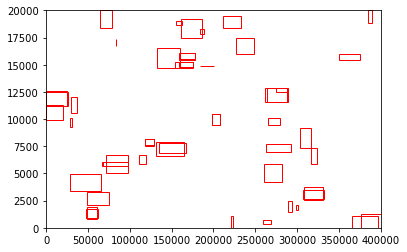

In [18]:
# from QueryGeneration import *
# random_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/random.csv')
# distribution_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/distribution.csv')
# fusion_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/fusion.csv')

# domains_ = [[1,4.00000000e+05],[1,2.00000000e+04]]
# domains_ = np.asarray(domains_)
# # plot_queries_2d(fusion_query, domains_)
# plot_queries_2d(distribution_query, domains_)

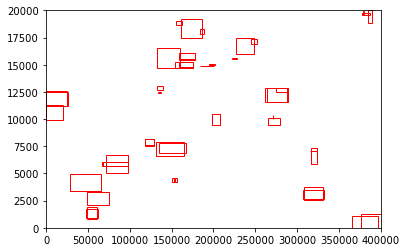

In [17]:
# filtered_distribution_query = filter_distribution_query(fusion_query, domains_, 1000, 1000, 2)
# plot_queries_2d(filtered_distribution_query, domains_)

In [453]:
# Notice: this will update the root_node in dict
# the queryset here should be the queries that believed to be those follow some distribution
def LKD_Robust(dataset, queryset, domains, min_block_size, bins, accu_count_list, kdnode_dict, root_node):
    
    root_node[-1] = -1
    root_node[-2] = -1
    kdnodes = [root_node]
    
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    dataset_dict = {} # the total dataset size should maintain the same as original
    dataset_dict.update({0:dataset})
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries, ONLY thise queries
    
    # accumulation histogram for fast query
    hist, edges = np.histogramdd(dataset, bins = bins)
    accu_hist = CreatePrefixSumHist(hist)
    
    can_split = True
    
    #print(kdnode_dict)
    if len(kdnode_dict) == 0:
        kdnode_dict.update({root_node[-4]:root_node}) # in case it's not in the dict
    
    accu_count = accu_count_list[0] # newly add attribute, the total kdnodes generated, including the intermediate
    
    while can_split:
        #print('current kdnodes: ', len(kdnodes)), for showing progress
        can_split = False
        
        for i in range(len(kdnodes)):
            
            if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
                continue
                
            # try to split
            benefits = []
            max_skip = 0
            max_skip_dim = 0
            max_skip_value = 0
            temp_dataset = np.copy(dataset_dict[i])
            
            for j in range(len(candidate_cut_pos)):
                
                is_split, skip = try_split_approximate(kdnodes[i], candidate_cut_pos[j], dataset, queryset, 
                                                       idx, min_block_size, accu_hist, domains)
                benefits.append(skip)
                
                if skip > max_skip:
                    max_skip = skip
                    max_skip_dim = candidate_cut_pos[j][0]
                    max_skip_value = candidate_cut_pos[j][1]
                    
            if max(benefits) <= 0:
                can_split = False
                break
            else:
                # perform split, at this place, we keep the exact size
                perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, kdnode_dict, accu_count)
                can_split = True
                accu_count += 2
    
    
    accu_count_list[0] = accu_count
    return kdnodes

In [454]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# root_node = [[[0,10],[0,10]],121,0,-1,-1,-1]
# kdnode_dict = {}
# accu_count_list = [0]

# tiny_qdtree_kdnodes = LKD_Robust(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size, 
#                                  (10,10),accu_count_list, kdnode_dict, root_node)

# print(tiny_qdtree_kdnodes)
# print("= = =")
# print(kdnode_dict)
# print("= = =")
# print(accu_count_list)
# print("= = =")
# print(root_node)

[[array([[0, 6],
       [0, 3]]), 28, 7, 3, -1, -1], [array([[ 6,  7],
       [ 0, 10]]), 11, 5, 2, -1, -1], [array([[ 0,  3],
       [ 5, 10]]), 20, 9, 4, -1, -1], [array([[ 7, 10],
       [ 0,  5]]), 18, 11, 6, -1, -1], [array([[0, 6],
       [3, 5]]), 14, 8, 3, -1, -1], [array([[ 3,  6],
       [ 5, 10]]), 15, 10, 4, -1, -1], [array([[ 7, 10],
       [ 5, 10]]), 15, 12, 6, -1, -1]]
= = =
{0: [[[0, 10], [0, 10]], 121, 0, -1, 1, 2], 1: [array([[ 0,  6],
       [ 0, 10]]), 77, 1, 0, 3, 4], 2: [array([[ 6, 10],
       [ 0, 10]]), 44, 2, 0, 5, 6], 3: [array([[0, 6],
       [0, 5]]), 42, 3, 1, 7, 8], 4: [array([[ 0,  6],
       [ 5, 10]]), 35, 4, 1, 9, 10], 5: [array([[ 6,  7],
       [ 0, 10]]), 11, 5, 2, -1, -1], 6: [array([[ 7, 10],
       [ 0, 10]]), 33, 6, 2, 11, 12], 7: [array([[0, 6],
       [0, 3]]), 28, 7, 3, -1, -1], 8: [array([[0, 6],
       [3, 5]]), 14, 8, 3, -1, -1], 9: [array([[ 0,  3],
       [ 5, 10]]), 20, 9, 4, -1, -1], 10: [array([[ 3,  6],
       [ 5, 10]]), 15, 10, 4

In [7]:
# # = = = Unit Test = = =
# subnode_ids = find_all_leafnode_ids(1, kdict)
# print(subnode_ids)

# subnode_ids = find_all_subnode_ids(1, kdict)
# print(subnode_ids)

In [476]:
# NOTICE: the root node will not be re inserted into the dict! But its children index will be changed
def KDPartition(dataset, current_dim, data_threshold, root_node, kdnode_dict, accu_count_list):
    
    current_size = len(dataset)
    if current_size <= data_threshold:
        return [root_node] # here we assume the children nodes are -1 and -1
        
    # try partition this node into 2
    median = np.median(dataset[:,current_dim])
    
    sub_domains1 = np.copy(root_node[0])
    sub_domains1[current_dim][1] = median
    sub_domains2 = np.copy(root_node[0])
    sub_domains2[current_dim][0] = median
    
    sub_dataset1 = dataset[dataset[:,current_dim] <= median]
    sub_dataset2 = dataset[dataset[:,current_dim] > median]
    
    if len(sub_dataset1) < data_threshold or len(sub_dataset2) < data_threshold:
        return [root_node]
    
    sub_kdnode_1 = [sub_domains1, len(sub_dataset1), accu_count_list[0] + 1, root_node[-4], -1, -1]
    sub_kdnode_2 = [sub_domains2, len(sub_dataset2), accu_count_list[0] + 2, root_node[-4], -1, -1]
    
    root_node[-2] = sub_kdnode_1[-4]
    root_node[-1] = sub_kdnode_2[-4]
    
    kdnode_dict.update({sub_kdnode_1[-4]: sub_kdnode_1})
    kdnode_dict.update({sub_kdnode_2[-4]: sub_kdnode_2})
    
    accu_count_list[0] += 2
    
    current_dim += 1
    if current_dim >= len(root_node[0]):
        current_dim %= len(root_node[0])
        
    kdnodes = []
    kdnodes += KDPartition(sub_dataset1, current_dim, data_threshold, sub_kdnode_1, kdnode_dict, accu_count_list)
    kdnodes += KDPartition(sub_dataset2, current_dim, data_threshold, sub_kdnode_2, kdnode_dict, accu_count_list)
    
    return kdnodes

def sub_dataset(dataset, domain):
    constraints = []
    for i in range(len(domain)):
        constraint_1 = dataset[:,i] >= domain[i][0]
        constraint_2 = dataset[:,i] < domain[i][1]
        constraints.append(constraint_1)
        constraints.append(constraint_2)
    constraint = np.all(constraints, axis=0)
    return dataset[constraint]


# perform kdtree partition for those nodes that are greater than 2*threshold
def post_kdnode_partition(kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list):
    
    processed_kdnodes = [] # the leaf nodes
    
    for i in range(len(kdnodes)):
        if kdnodes[i][1] > 2 * data_threshold:
            temp_dataset = sub_dataset(dataset, kdnodes[i][0])
            if kdnodes[i][-4] == 8:
                print('process node 8 in post_partition (before): ', kdnodes[i])
            processed_kdnodes += KDPartition(temp_dataset, 0, data_threshold, kdnodes[i], kdnode_dict, accu_count_list)
            if kdnodes[i][-4] == 8:
                print('process node 8 in post_partition (after): ', kdnodes[i])
        else:
            processed_kdnodes.append(kdnodes[i])
    
    return processed_kdnodes

In [456]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# # defined in the LKD_Robust unit test
# # root_node = [[[0,10],[0,10]],121,0,-1,-1,-1]
# # kdnode_dict = {}
# # accu_count_list = [0]

# # processed_kdnodes = KDPartition(tiny_dataset, 0, 5, root_node, kdnode_dict, accu_count_list)

# processed_kdnodes = post_kdnode_partition(tiny_qdtree_kdnodes, 5, tiny_dataset, kdnode_dict, accu_count_list)
# print(processed_kdnodes)
# print("= = =")
# print(kdnode_dict)
# print("= = =")
# print(accu_count_list)
# print("= = =")
# print(root_node)

process node 8 in post_partition (before):  [array([[0, 6],
       [3, 5]]), 14, 8, 3, -1, -1]
process node 8 in post_partition (after):  [array([[0, 6],
       [3, 5]]), 14, 8, 3, 19, 20]
[[array([[0, 2],
       [0, 3]]), 9, 13, 7, -1, -1], [array([[2, 6],
       [0, 3]]), 9, 14, 7, -1, -1], [array([[ 6,  7],
       [ 0, 10]]), 11, 5, 2, -1, -1], [array([[ 0,  1],
       [ 5, 10]]), 10, 15, 9, -1, -1], [array([[ 1,  3],
       [ 5, 10]]), 5, 16, 9, -1, -1], [array([[7, 8],
       [0, 5]]), 10, 17, 11, -1, -1], [array([[ 8, 10],
       [ 0,  5]]), 5, 18, 11, -1, -1], [array([[0, 2],
       [3, 5]]), 6, 19, 8, -1, -1], [array([[2, 6],
       [3, 5]]), 6, 20, 8, -1, -1], [array([[ 3,  4],
       [ 5, 10]]), 10, 21, 10, -1, -1], [array([[ 4,  6],
       [ 5, 10]]), 5, 22, 10, -1, -1], [array([[ 7,  8],
       [ 5, 10]]), 10, 23, 12, -1, -1], [array([[ 8, 10],
       [ 5, 10]]), 5, 24, 12, -1, -1]]
= = =
{0: [[[0, 10], [0, 10]], 121, 0, -1, 1, 2], 1: [array([[ 0,  6],
       [ 0, 10]]), 77

In [488]:
def LKD_Robust_Initialization(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    
    filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node)
    processed_kdnodes = post_kdnode_partition(qdtree_kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list)
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    # create index for the kdnodes
    kdnode_idx = index.Index(properties = p) # Rtree index
    for i in range(len(processed_kdnodes)):
        if processed_kdnodes[i][-4] == 164:
            print('insert 164 at initialization')
        kdnode_idx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])

    query_idx = index.Index(properties = p) # Rtree index
    for i in range(len(queryset)):
        query_idx.insert(i, (queryset[i][0][0],queryset[i][1][0],queryset[i][0][1],queryset[i][1][1]), queryset[i])
        
    return processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

In [489]:
# window size should be the same as initial queryset size
# the initial 
def LKD_Robust_Incremental(dataset, window_size, initial_queryset, continous_queryset, kdnode_dict, kdnode_idx, query_idx, query_hist, 
                           accu_count_list, domain, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5):
    
    initial_query_size = query_idx.get_size()
        
    total_queryset = initial_queryset + continous_queryset
    total_queryset = np.array(total_queryset)
    
    for i in range(initial_query_size, len(total_queryset)):
        print(i)
        # add new query
        hist_region_index = InserQueryIntoHist(i, total_queryset[i], query_hist, domain, hist_m, hist_n, query_threshold)
        
        query_idx.insert(i, query_2_border(total_queryset[i]), total_queryset[i])
        
        if len(hist_region_index) > 0:
            #print(hist_region_index)
            repartition_for_adaptation(total_queryset, hist_region_index, hist_m, hist_n, dataset, domain, data_threshold, 
                                       query_threshold, kdnode_idx, query_idx, kdnode_dict, accu_count_list)
        
        # TODO: this should also include the robustness operation, i.e., post_partition !!!
        
        if i < window_size:
            continue
        
        # remove old query
        hist_region_index = RemoveQueryFromHist(i-window_size, total_queryset[i-window_size], query_hist, 
                                                domain, hist_m, hist_n, query_threshold)
        
        query_idx.delete(i-window_size, query_2_border(total_queryset[i-window_size]))
        
        if len(hist_region_index) > 0:
            # repartition for robustness
            repartition_for_robustness(hist_region_index, hist_m, hist_n, dataset, domain, data_threshold, query_threshold, 
                                        kdnode_idx, query_idx, kdnode_dict, accu_count_list)  
    
    return kdnode_dict, kdnode_idx, query_idx, query_hist

In [188]:
def load_query(path):
    query_set = np.genfromtxt(path, delimiter=' ')
    query_set = query_set.reshape(len(query_set),-1,2)
    return query_set

In [189]:
# = = = Unit Test = = =
original_domains = [\
    [1,1.20000000e+07],\
    [1,4.00000000e+05],\
    [1,2.00000000e+04],\
    [1,7.00000000e+00],\
    [1,5.00000000e+01],\
    [900.99,1.04899500e+05],\
    [0,1.00000000e-01],\
    [0,8.00000000e-02]\
]
original_domains = np.asarray(original_domains)
# original_dataset = genfromtxt('/Users/lizhe/Desktop/LearnedKDTree/DataAndWorkload/SyntheticData/TPCH_12M_8Field.csv', delimiter=',')
original_dataset = np.genfromtxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Legacy/data/TPCH_12M_8Field.csv', delimiter=',')
used_dimensions = [1,2]
dataset = np.copy(original_dataset)
dataset = dataset[:,used_dimensions]
domains_ = original_domains[used_dimensions]

In [490]:
# = = = Unit Test = = =
fusion_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/fusion.csv') # 100

In [491]:
data_threshold = 5000
query_threshold = 5
hist_m, hist_n = 1000, 1000

In [492]:
# = = = Unit Test = = =
processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization(
    dataset, fusion_query, domains_, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

process node 8 in post_partition (before):  [array([[1.32557467e+05, 1.75056528e+05],
       [1.00000000e+00, 1.46852314e+04]]), 934456, 8, 3, -1, -1]
process node 8 in post_partition (after):  [array([[1.32557467e+05, 1.75056528e+05],
       [1.00000000e+00, 1.46852314e+04]]), 934456, 8, 3, 1417, 1418]
insert 164 at initialization


In [493]:
# print(processed_kdnodes[0:20])
for i in range(len(processed_kdnodes)):
    if processed_kdnodes[i][-3] == 8:
        print(processed_kdnodes[i])

In [494]:
# = = = Unit Test = = =
print(len(processed_kdnodes))
print(len(kdnode_dict))
print(kdnode_idx)
print(accu_count_list)
print(query_idx)
# print(query_hist)

1537
3073
rtree.index.Index(bounds=[1.0, 1.0, 400000.0, 20000.0], size=1537)
[3072]
rtree.index.Index(bounds=[1.0, 1.0, 400000.0, 20000.0], size=100)


In [495]:
# = = = Unit Test = = =
continous_fusion_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/continous_fusion.csv') #

In [496]:
if not isinstance(fusion_query, list):
    fusion_query = fusion_query.tolist()
if not isinstance(continous_fusion_query, list):
    continous_fusion_query = continous_fusion_query.tolist()

In [497]:
# = = = Unit Test = = =
window_size = 100
kdnode_dict, kdnode_idx, query_idx, query_hist = LKD_Robust_Incremental(
    dataset, window_size, fusion_query, continous_fusion_query, kdnode_dict, kdnode_idx, query_idx, query_hist, 
    accu_count_list, domains_, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099


In [30]:
import statistics

def Query(queries, kdnodes):
    
    counts_partitions = []
    counts_records = []
    counts_total = 0
    
    count_single_query = 0;
    count_single_query_records = 0
    
    # number of dimensions
    dims = int(len(queries[0]))
    
    # for each query
    for i in range(len(queries)):
        
        count_single_query = 0
        count_single_query_records = 0
        
        # check for intersection for each kdnode
        for j in range(len(kdnodes)):
            
            intersection_tag = True
            
            # for each dimension
            for k in range(dims):
                
                # an intersection holds if it intersecs in all dimensions
                if queries[i][k][0] >= kdnodes[j][0][k][1] or queries[i][k][1] <= kdnodes[j][0][k][0]:
                    intersection_tag = False
                    break
                
            # if the query intersect with this kdnode
            if intersection_tag:
                count_single_query += 1
                count_single_query_records += kdnodes[j][1] # number of records in this partition
            
        counts_partitions.append(count_single_query)
        counts_records.append(count_single_query_records)
        counts_total += count_single_query_records
    
    #print("blocks IO: ", counts)
    print("average partitions each query overlap(average): ", statistics.mean(counts_partitions))
    print("average records each query retrieve(average): ", statistics.mean(counts_records))
    print("total records that all the queries retrieve: ", counts_total)

In [32]:
testing_set = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/testing.csv')
Query(testing_set, processed_kdnodes)

average partitions each query overlap(average):  6.46
average records each query retrieve(average):  48976.34
total records that all the queries retrieve:  2448817


In [472]:
# === KDTree Visualization ===
#
# restricted to 2D
#
# @kdnodes: the generated kdnodes, domains in them are ordered according to the learned split dimension order,
#   should only generated on the domains for visualization?
# @query: the query in the query dimension order, should be the same as the order of 'kdnode domains'
# @domains: the domains for visualization, should be in the origin order
# @realtive_order: whether to adjust the order of domains in kdnodes to corresponding the 'domains' parameteer
#
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def visualize_kdnodes_and_query(kdnodes, query, domains):
    
    fig, ax = plt.subplots(1)
    
    plt.xlim(domains[0][0],domains[0][1])
    plt.ylim(domains[1][0],domains[1][1])
    # transform the queries into boxes
    
    # first plot all the kdnodes
    for i in range(len(kdnodes)):
        
        kd_domains = kdnodes[i][0]
        kd_domains = np.asarray(kd_domains)
        
        lower1 = kd_domains[0][0]
        upper1 = kd_domains[0][1]
        lower2 = kd_domains[1][0]
        upper2 = kd_domains[1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='b',linewidth=1)
        ax.add_patch(rect)
    
    # plot the queries
    for i in range(len(query)):
        
        lower1 = query[i][0][0]
        upper1 = query[i][0][1]
        lower2 = query[i][1][0]
        upper2 = query[i][1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=3)
        ax.add_patch(rect)
        
    plt.show()

In [498]:
LKD_Robust_kdnodes = []
for key,value in kdnode_dict.items():
    if value[-1] == -1 and value[-2] == -1:
        LKD_Robust_kdnodes.append(value)

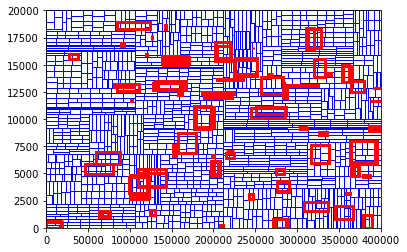

In [499]:
visualize_kdnodes_and_query(LKD_Robust_kdnodes, continous_fusion_query[-100:], domains_)

In [500]:
# Test Query Cost
Query(continous_fusion_query[-100:], LKD_Robust_kdnodes)

average partitions each query overlap(average):  7.76
average records each query retrieve(average):  55316.46
total records that all the queries retrieve:  5531646


In [ ]:
# consider the baseline of using the last 100 queries
qd_root_node = [domains_, len(dataset), 0, -1, -1, -1]
qd_kdnode_dict = {}
pure_Qd_Tree_kdnodes = LKD_Robust(dataset, queryset, domains, min_block_size, (1000,1000), accu_count_list, qd_kdnode_dict, qd_root_node)